In [1]:
%load_ext autoreload

In [65]:
%autoreload 2
import os, json, glob
import matplotlib.pyplot as plt
import librosa, mir_eval
import numpy as np
from f0_analysis_utils import *

## F0 (evaluation with pitch)

In [4]:
def f0_note_tracker(file, pitch_diff_thres=0.8, note_dur_thres=80):
    """Note tracking based on F0 segmentation

    This function takes a file as input, suitable for individually testing this component.

    When taking audio segments returned by monophony detector, 
    the function needs to take audio signal as input

    Args:
        file (str): filename of the mono audio segment
        pitch_diff_thres (float, optional): The F0 curve are cut into note events are points 
        where the pitch difference betweentwo adjacent frames exceeds this threshold. Defaults to 0.8.
        note_dur_thres (int, optional): A valid note event must last longer than this threshold in ms. Defaults to 80.

    Returns:
        list, list: Estimated intervals: [(onset, offset)], and estimated pitches: [pitch]
    """
    est_intervals = []
    est_pitches = []
    times, notes = load_audio_file(file)
    f0_segments = get_continous_f0_segments(notes, dur_thres=note_dur_thres)
    for f0_segment in f0_segments:
        note_events = get_note_events_from_f0_segment(notes, f0_segment, f0_change_thres=pitch_diff_thres, dur_thres=note_dur_thres)
        for note_event in note_events:
            onset = times[note_event[0]]
            offset = times[note_event[-1]]
            pitch = np.mean(notes[note_event])
            pitch_hz = librosa.midi_to_hz(pitch)
            est_intervals.append([onset, offset])
            est_pitches.append(pitch_hz)
    est_intervals = np.array(est_intervals)
    est_pitches = np.array(est_pitches)
    return est_intervals, est_pitches

In [5]:
def eval_f0_note_tracker(file, pitch_diff_thres=0.8, note_dur_thres=80):
    """First call `f0_note_tracker` to estimate intervals and pitches. 
    Then evaluate the result by comparing estimated note events against 
    ground truth annotations.
    
    This evaluates the estimated onset and pitch. 
    The two parameters to be tuned: `pitch_diff_thres` and `note_dur_thres`

    Args:
        file (str): The filename of a mono audio segment.
        pitch_diff_thres (float): The F0 curve is cut into two notes if the pitch difference between two adjacent frames exceeds this threshold.
        note_dur_thres (int): A valid note event must last longer than this threshold (in ms).

    Returns:
        tuple: scores returned by `mir_eval`
    """
    est_intervals, est_pitches = f0_note_tracker(file, pitch_diff_thres, note_dur_thres)
    
    anno_file = find_anno(file)
    ref_intervals = []
    ref_pitches = []
    with open(anno_file) as anno:
        annotation = json.load(anno)
    for note_event in annotation:
        onset = note_event["time"]["start"]
        offset = onset + note_event["time"]["dur"]
        pitch = note_event["pitch"]
        pitch_hz = librosa.midi_to_hz(pitch)
        ref_intervals.append([onset, offset])
        ref_pitches.append(pitch_hz)
    ref_intervals = np.array(ref_intervals)
    ref_pitches = np.array(ref_pitches)

    score = mir_eval.transcription.evaluate(ref_intervals, ref_pitches, est_intervals, est_pitches)
    return score

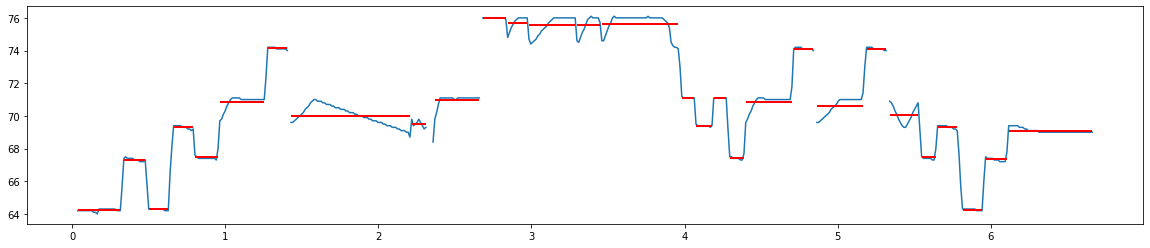

In [83]:
# clean tone
file = "ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_45_122s.wav"
times, notes = load_audio_file(file)
intervals, pitches = f0_note_tracker(file, pitch_diff_thres=1, note_dur_thres=75)

plt.figure(figsize=(20,4))
plt.plot(times, notes)
for i in range(intervals.shape[0]):
    pitch = librosa.hz_to_midi(pitches[i])
    plt.hlines(y=pitch, xmin=intervals[i][0], xmax=intervals[i][1], linewidth=2, color='r')


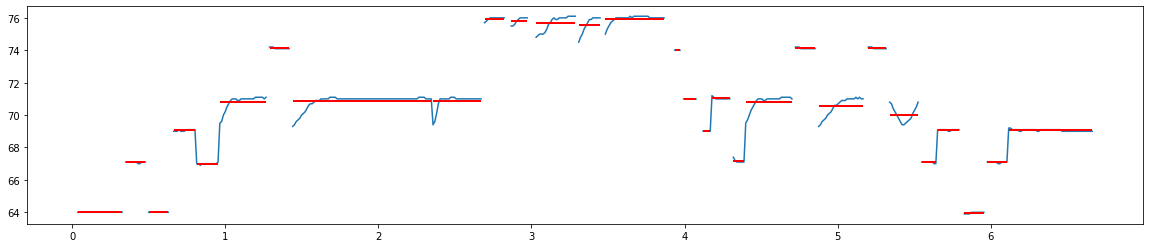

In [7]:
# origin tone
file = "ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_45_122s.wav"
ORIGIN_AUDIO_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/original_tone/mono_audio_segments_filtered"
y, sr = librosa.load(os.path.join(ORIGIN_AUDIO_DIR, file), sr=None)
f0, _, _ = librosa.pyin(
    y,
    fmin=librosa.note_to_hz("C2"),
    fmax=librosa.note_to_hz("G6"),
    sr=sr,
    center=False,
)
times = librosa.times_like(f0, sr=sr, hop_length=512, n_fft=2048)
# convert F0 sequence to MIDI note sequence
notes = librosa.hz_to_midi(f0)

intervals, pitches = f0_note_tracker(os.path.join(ORIGIN_AUDIO_DIR, file), pitch_diff_thres=1, note_dur_thres=75)

plt.figure(figsize=(20,4))
plt.plot(times, notes)
for i in range(intervals.shape[0]):
    pitch = librosa.hz_to_midi(pitches[i])
    plt.hlines(y=pitch, xmin=intervals[i][0], xmax=intervals[i][1], linewidth=2, color='r')

In [77]:
# calculate score for one file
file = "ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_45_122s.wav"

anno_file = find_anno(file)
ref_intervals = []
ref_pitches = []
with open(anno_file) as anno:
    annotation = json.load(anno)
for note_event in annotation:
    onset = note_event["time"]["start"]
    offset = onset + note_event["time"]["dur"]
    pitch = note_event["pitch"]
    pitch_hz = librosa.midi_to_hz(pitch)
    ref_intervals.append([onset, offset])
    ref_pitches.append(pitch_hz)
ref_intervals = np.array(ref_intervals)
ref_pitches = np.array(ref_pitches)

In [78]:
est_intervals, est_pitches = f0_note_tracker(file, pitch_diff_thres=0.8, note_dur_thres=80)

In [79]:
mir_eval.transcription.evaluate(ref_intervals, ref_pitches, est_intervals, est_pitches)

OrderedDict([('Precision', 0.5666666666666667),
             ('Recall', 0.53125),
             ('F-measure', 0.5483870967741935),
             ('Average_Overlap_Ratio', 0.7663269044100365),
             ('Precision_no_offset', 0.6),
             ('Recall_no_offset', 0.5625),
             ('F-measure_no_offset', 0.5806451612903225),
             ('Average_Overlap_Ratio_no_offset', 0.7452633630384912),
             ('Onset_Precision', 0.9333333333333333),
             ('Onset_Recall', 0.875),
             ('Onset_F-measure', 0.9032258064516129),
             ('Offset_Precision', 0.9666666666666667),
             ('Offset_Recall', 0.90625),
             ('Offset_F-measure', 0.9354838709677419)])

In [ ]:
# batch processing
FILTERED_AUDIO_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/clean_tone/mono_audio_segments_filtered"
audio_files = sorted(glob.glob(os.path.join(FILTERED_AUDIO_DIR, "*.wav")), key=os.path.getsize, reverse=True)

In [99]:
scores = []
i = 0

for file in audio_files:
    print(file.split("/")[-1], i)
    score = eval_f0_note_tracker(file, pitch_diff_thres=0.8, note_dur_thres=80)
    scores.append(score)
    i += 1

Metallica - The Day That Never Comes_Harmony_0_0s.wav 0
Queen - Bohemian Rhapsody_Gtr 1_0_0s.wav 1
Metallica - Seek And Destroy (ver 2)_Gtr. III_0_0s.wav 2


In [98]:
import csv
field_names = score.keys()
with open('score.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    writer.writerows(scores)

## Onset

In [76]:
def onset_note_tracker(file):
    y, sr = librosa.load(os.path.join(FILTERED_AUDIO_DIR, file), sr=None)
    # optional: normalize the signal
    y = y / np.max(abs(y))
    est_intervals = []
    onsets = librosa.onset.onset_detect(y=y, sr=sr, units='time')
    for i in range(len(onsets)-1):
        onset = onsets[i]
        offset = onsets[i+1]
        est_intervals.append([onset, offset])
    if len(est_intervals) == 0:
        est_intervals.append([0, len(y)/sr])
    est_intervals = np.array(est_intervals)
    return est_intervals

def eval_onset_note_tracker(file, onset_tol=0.05, offset_tol=0.05, offset_ratio=0.2):
    est_intervals = onset_note_tracker(file)

    anno_file = find_anno(file)
    ref_intervals = []
    with open(anno_file) as anno:
        annotation = json.load(anno)
    for note_event in annotation:
        onset = note_event["time"]["start"]
        offset = onset + note_event["time"]["dur"]
        ref_intervals.append([onset, offset])
    ref_intervals = np.array(ref_intervals)

    onset_match = mir_eval.transcription.match_note_onsets(ref_intervals, est_intervals, onset_tolerance=onset_tol)
    offset_match = mir_eval.transcription.match_note_offsets(ref_intervals, est_intervals, offset_min_tolerance=offset_tol, offset_ratio=offset_ratio)
    match = [i for i in onset_match if i in offset_match]

    return len(est_intervals), len(ref_intervals), len(match)
    

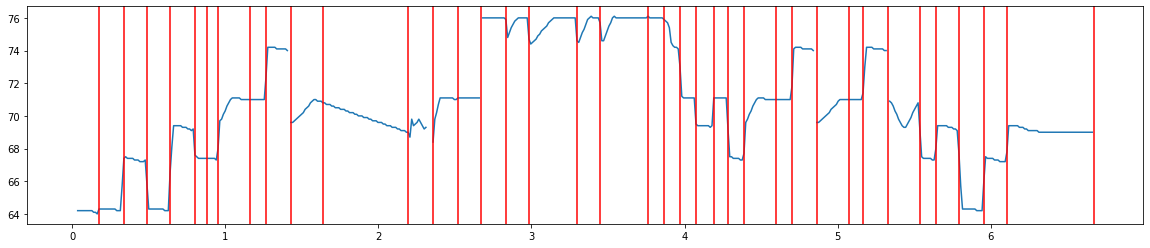

In [53]:
file = "ACDC - Back In Black (ver 4 by GuitarManiac09)_Angus Young_45_122s.wav"
y, sr = librosa.load(os.path.join(FILTERED_AUDIO_DIR, file), sr=None)
est_intervals = []
onsets = librosa.onset.onset_detect(y=y, sr=sr, units='time')

times, notes = load_audio_file(file)
plt.figure(figsize=(20, 4))
plt.plot(times, notes)
for onset in onsets:
    plt.axvline(onset, color='r')


In [46]:
FILTERED_AUDIO_DIR = "/Volumes/MacOnly/UG_proc/all_time_top_by_hits/original_tone/mono_audio_segments_filtered"
audio_files = glob.glob(os.path.join(FILTERED_AUDIO_DIR, "*.wav"))
# audio_files = sorted(glob.glob(os.path.join(FILTERED_AUDIO_DIR, "*.wav")), key=os.path.getsize, reverse=True)

In [78]:
# onset detection-based note tracker (clean):
# over all dataset: precision 0.8796, recall 0.8508, f-score 0.8650
# onset detection-based note tracker (origin 0.05 tolerance):
# over all dataset: precision 0.6643, recall 0.6969, f-score 0.6802
# onset detection-based note tracker (origin 0.1 tolerance):
# over all dataset: precision 0.6694, recall 0.7022, f-score 0.6854
# onset detection-based note tracker (origin 0.2 tolerance):
# over all dataset: precision 0.6977, recall 0.7320, f-score 0.7144
# onset detection-based note tracker (origin 0.5 tolerance):
# over all dataset: precision 0.7217, recall 0.7571, f-score 0.7390
est_total = 0
ref_total = 0
match_total = 0
i = 0
for file in audio_files:
    est_cnt, ref_cnt, match_cnt = eval_onset_note_tracker(file, onset_tol=0.05, offset_tol=0.05, offset_ratio=0.5)
    est_total += est_cnt
    ref_total += ref_cnt
    match_total += match_cnt
    # print(est_cnt, ref_cnt, match_cnt)
    i += 1
    if i == 500:
        break
precision = match_total / est_total
recall = match_total / ref_total
f_score = (2*precision*recall) / (precision + recall)
print(precision, recall, f_score)

0.6504196255648805 0.7782927771340286 0.7086337260418498


## F0 (evaluation without pitch)

In [42]:
def f0_note_tracker(file, pitch_diff_thres=0.8, note_dur_thres=80):
    est_intervals = []
    times, notes = load_audio_file(file)
    f0_segments = get_continous_f0_segments(notes, dur_thres=note_dur_thres)
    for f0_segment in f0_segments:
        note_events = get_note_events_from_f0_segment(notes, f0_segment, f0_change_thres=pitch_diff_thres, dur_thres=note_dur_thres)
        for note_event in note_events:
            onset = times[note_event[0]]
            offset = times[note_event[-1]]
            est_intervals.append([onset, offset])
    if len(est_intervals) == 0:
        est_intervals.append([0, times[-1]])
    est_intervals = np.array(est_intervals)
    return est_intervals

def eval_f0_note_tracker(file, pitch_diff_thres=0.8, note_dur_thres=80):
    est_intervals = f0_note_tracker(file, pitch_diff_thres, note_dur_thres)
    anno_file = find_anno(file)
    ref_intervals = []
    with open(anno_file) as anno:
        annotation = json.load(anno)
    for note_event in annotation:
        onset = note_event["time"]["start"]
        offset = onset + note_event["time"]["dur"]
        ref_intervals.append([onset, offset])
    ref_intervals = np.array(ref_intervals)

    onset_match = mir_eval.transcription.match_note_onsets(ref_intervals, est_intervals)
    offset_match = mir_eval.transcription.match_note_offsets(ref_intervals, est_intervals)
    match = [i for i in onset_match if i in offset_match]

    return len(est_intervals), len(ref_intervals), len(match)

In [40]:
audio_files = glob.glob(os.path.join(FILTERED_AUDIO_DIR, "*.wav"))
# audio_files = sorted(glob.glob(os.path.join(FILTERED_AUDIO_DIR, "*.wav")), key=os.path.getsize, reverse=True)

In [41]:
est_total = 0
ref_total = 0
match_total = 0
i = 0
for file in audio_files:
    est_cnt, ref_cnt, match_cnt = eval_f0_note_tracker(file, pitch_diff_thres=0.8, note_dur_thres=80)
    est_total += est_cnt
    ref_total += ref_cnt
    match_total += match_cnt
    # print(est_cnt, ref_cnt, match_cnt)
    i += 1
    if i == 50:
        break
precision = match_total / est_total
recall = match_total / ref_total
f_score = (2*precision*recall) / (precision + recall)
print(precision, recall, f_score)

0.7149220489977728 0.626953125 0.668054110301769


In [43]:
est_total = 0
ref_total = 0
match_total = 0
i = 0
for file in audio_files:
    est_cnt, ref_cnt, match_cnt = eval_f0_note_tracker(file, pitch_diff_thres=0.5, note_dur_thres=0)
    est_total += est_cnt
    ref_total += ref_cnt
    match_total += match_cnt
    # print(est_cnt, ref_cnt, match_cnt)
    i += 1
    if i == 50:
        break
precision = match_total / est_total
recall = match_total / ref_total
f_score = (2*precision*recall) / (precision + recall)
print(precision, recall, f_score)

0.3091715976331361 0.408203125 0.3518518518518518


In [44]:
est_total = 0
ref_total = 0
match_total = 0
i = 0
for file in audio_files:
    est_cnt, ref_cnt, match_cnt = eval_f0_note_tracker(file, pitch_diff_thres=0.5, note_dur_thres=70)
    est_total += est_cnt
    ref_total += ref_cnt
    match_total += match_cnt
    # print(est_cnt, ref_cnt, match_cnt)
    i += 1
    if i == 50:
        break
precision = match_total / est_total
recall = match_total / ref_total
f_score = (2*precision*recall) / (precision + recall)
print(precision, recall, f_score)

0.7203389830508474 0.6640625 0.6910569105691058
